In [13]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns       
import pandas as pd                           # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

In [14]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

# Problem 3

In [15]:
r = np.random
r.seed(42)

save_plots = False   
N_points = 10000      # Number of random points to be produced!

xmin = 0.0
xmax = 1.0
N_bins = 100

# Define f(x) = 2x, for x in [0,1]
def fx_2x(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N * 8.0125*x**3*np.sin(np.pi*x)

In [16]:
N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = 3.0      # Maximum value the function will take!
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < 8.0125*x_test**3*np.sin(np.pi*x_test)):
            break
            
    x_accepted[i] = x_test

In [17]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!


Integral of f(x) = x, x in [0, 1] is: 	  0.9943 +- 0.0081
The efficiency of the Accept/Reject method used here is: 	 33.14% +/- 0.27%


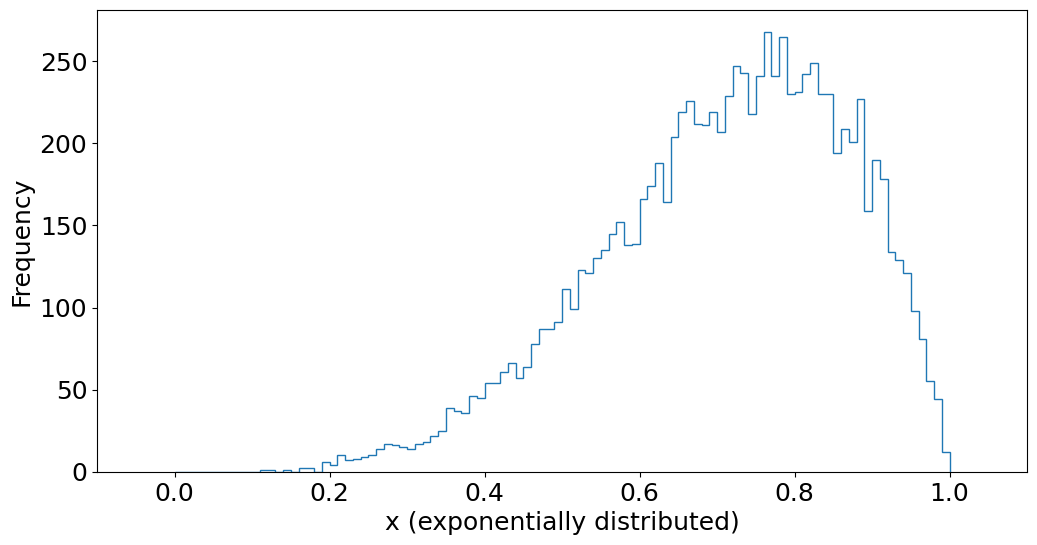

In [18]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));

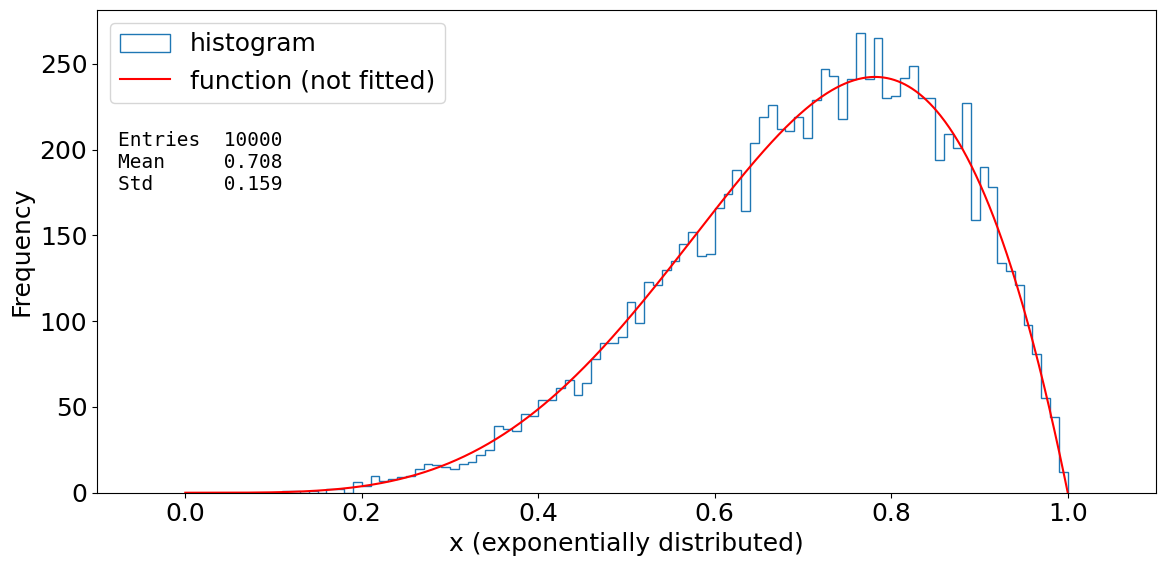

In [19]:
# Plot f(x)
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_2x(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# Define the figure text
d2 = {'Entries': len(x_accepted),
      'Mean': x_accepted.mean(),
      'Std': x_accepted.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.75, text2, ax2, fontsize=14)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("Hist_2x_AcceptRejectMethod.pdf", dpi=600)
    
# Show the figure
fig2

In [20]:
def f_fit(x,a):
    return N_points/N_bins*8.0125*x**a*np.sin(np.pi*x)

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_accepted, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

chi2fit = Chi2Regression(f_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,a=1)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.05                      │              Nfcn = 33               │
│ EDM = 4.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   3.021   │   0.022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000487 │
└───┴──────────┘

In [21]:
def chi2_owncalc(x,a):
	y_fit = f_fit(x,a)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

In [22]:
#Calculate degrees of freedom
print(len(y[y>0])-1)

85


In [23]:
print(chi2_owncalc(x,3), stats.chi2.sf(chi2_owncalc(x,3), 85))

64.95516105014211 0.9480173429231933


# Problem 4.1

In [31]:
def read_grip(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["Dominant hand", "Dominant grip", "Non Dominant grip"]) 
	return dat

grip_strength = read_grip("data_GripStrength.txt")
Dom_hand = grip_strength["Dominant hand"]
Dom_grip = grip_strength["Dominant grip"]
Non_Dom_grip = grip_strength["Non Dominant grip"]

In [64]:
count = 0 
for i in Dom_hand:
	if i == 1:
		count +=1

print(f'The amount of people that are right handed are {np.round(count/len(Dom_hand), 2)}')
print(f'The mean of the Dominant grip is {np.mean(Dom_grip)} with a standard deviation of {np.std(Dom_grip)}')
print(f'The mean of the Dominant grip is {np.mean(Non_Dom_grip)} with a standard deviation of {np.std(Non_Dom_grip)}')
print(f'The mean of the Dominant grip is {np.mean(Dom_grip-Non_Dom_grip)} with a standard deviation of {np.std(Dom_grip-Non_Dom_grip)}')


The amount of people that are right handed are 0.81
The mean of the Dominant grip is 444.93095238095236 with a standard deviation of 144.14294632510968
The mean of the Dominant grip is 418.48178571428565 with a standard deviation of 137.3924578851255
The mean of the Dominant grip is 26.449166666666674 with a standard deviation of 29.034518053366583


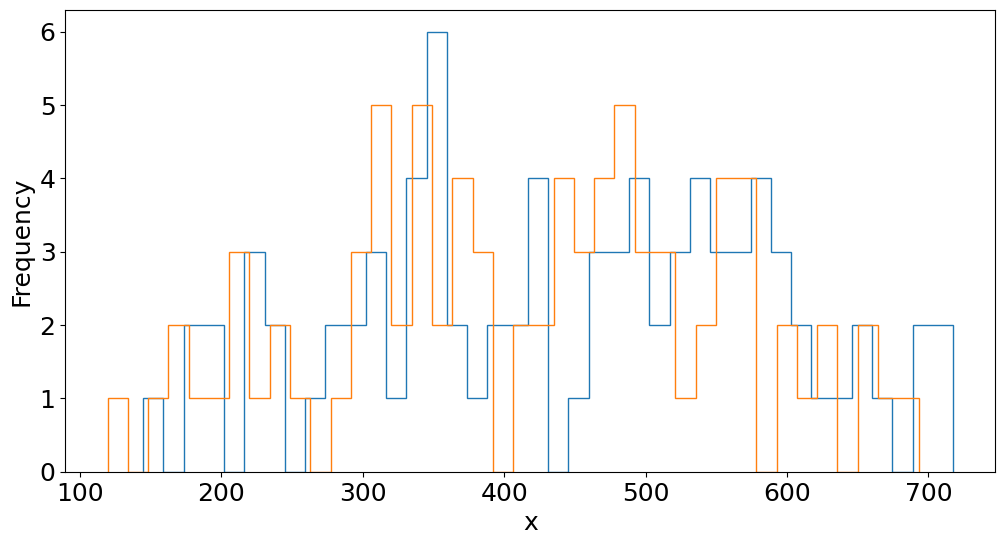

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(Dom_grip, bins=40, histtype='step', label='histogram' )
ax.set(xlabel="x", ylabel="Frequency");
ax.hist(Non_Dom_grip, bins=40, histtype='step', label='histogram' )


plt.show()


# Problem 4.2

In [68]:
def read_molecule(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["size", "intensity"]) 
	return dat

Molecule = read_molecule("data_MoleculeTypes.txt")
size = Molecule["size"]
intensity = Molecule["intensity"]

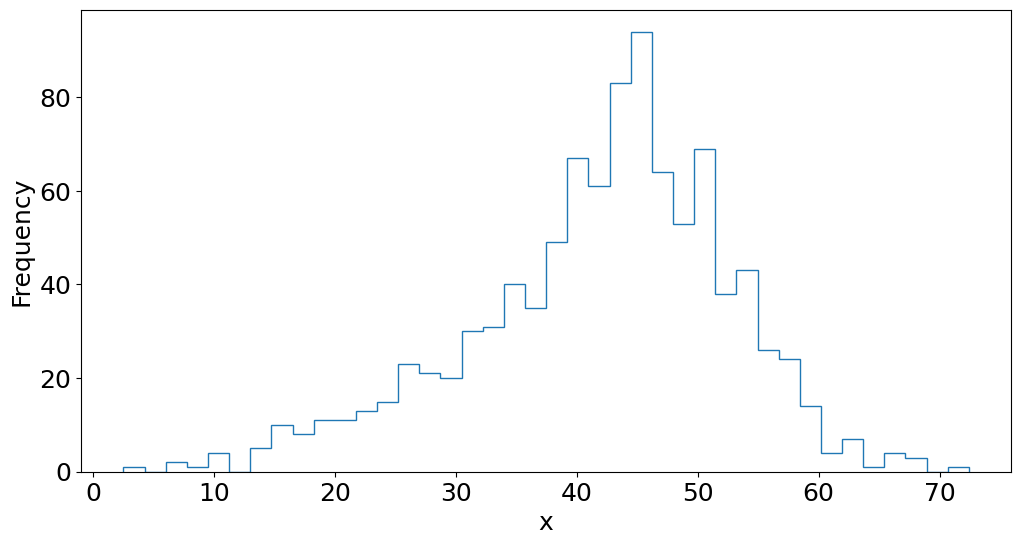

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size, bins=40, histtype='step', label='histogram')
ax.set(xlabel="x", ylabel="Frequency");